In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from rascal.atlas import Atlas

from lvmdrp.core.constants import LVM_UNAM_URL
from lvmdrp.utils.examples import GAINS, RDNOISES
from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata

from lvmdrp.core import rss, image, spectrum1d
from lvmdrp.functions import imageMethod, rssMethod


/home/mejia/Downloads/home/mejia/.local/bin/miniconda3/envs/lvmdrp/lib/python3.8/site-packages/rascal/calibrator.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.{ext}")

In [3]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False)
# group by imagetyp, camera and exptime
frames_table = frames_table.group_by(["imagetyp", "spec", "camera", "expnum", "exptime"])
# define groups and unique categories in those groups
frames_groups = frames_table.groups
unique_groups = frames_groups.keys

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/frames_table.pkl'


In [4]:
cameras = ["b", "r", "z"]
spec = 1
for camera in cameras:
    biases = frames_groups[(unique_groups["imagetyp"]=="bias")&(unique_groups["spec"]==f"sp{spec}")&(unique_groups["camera"]==f"{camera}{spec}")]
    biases.pprint(max_width=200)
    
#     # let's pre-process the all bias frames
#     pbias_paths = []
#     for bias_frame in biases:
#         bias_path = bias_frame["path"]
#         bias_camera, bias_expnum = bias_frame["camera"], bias_frame["expnum"]

#         pbias_path = out_path.format(kind="pbias", camera=bias_camera, expnum=bias_expnum, ext="fits")

#         imageMethod.preprocRawFrame_drp(
#             in_image=bias_path,
#             out_image=pbias_path,
#             subtract_overscan=False, unit="e-", compute_error=False
#         )
#         pbias_paths.append(pbias_path)

#     mbias_path = os.path.join(output_path, f"lvm-mbias-{bias_camera}.fits")
#     imageMethod.createMasterFrame_drp(
#         in_images=pbias_paths,
#         out_image=mbias_path.format(camera=bias_camera, ext="fits"),
#     )

imagetyp spec camera  expnum  exptime                                                                   path                                                                 
-------- ---- ------ -------- ------- ---------------------------------------------------------------------------------------------------------------------------------------
    bias  sp1     b1 00000025     0.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60009/sdR-s-b1-00000025.fits.gz
    bias  sp1     b1 00000028     0.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60009/sdR-s-b1-00000028.fits.gz
    bias  sp1     b1 00000035     0.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60009/sdR-s-b1-00000035.fits.gz
    bias  sp1     b1 00000175     0.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/d

In [5]:
# identify fiberflat
fiberflats = frames_groups[(unique_groups["imagetyp"]=="object")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00000199")]
fiberflats.pprint(max_width=200)

for fiberflat_frame in fiberflats:
    fiberflat_path = fiberflat_frame["path"]
    fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]
    
    imageMethod.preprocRawFrame_drp(
        in_image=fiberflat_path,
        out_image=out_path.format(kind="pfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        subtract_overscan=True, unit="e-", compute_error=True,
        assume_imagetyp="fiberflat"
    )
    # imageMethod.LACosmic_drp(
    #     in_image=out_path.format(kind="pfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
    #     out_image=out_path.format(kind="rfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
    #     iter=1, increase_radius=1, flim=1.3, parallel="auto"
    # )
    imageMethod.basicCalibration_drp(
        in_image=out_path.format(kind="pfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        out_image=out_path.format(kind="cfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        # in_bias=mbias_path.format(camera=fiberflat_camera, ext="fits"),
        # in_pixelflat=mpixelflat_path.format(camera=fiberflat_camera, ext="fits")
    )

imagetyp spec camera  expnum  exptime                                                                   path                                                                 
-------- ---- ------ -------- ------- ---------------------------------------------------------------------------------------------------------------------------------------
  object  sp1     b1 00000199   240.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60010/sdR-s-b1-00000199.fits.gz
  object  sp1     r1 00000199   240.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60010/sdR-s-r1-00000199.fits.gz
  object  sp1     z1 00000199   240.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60010/sdR-s-z1-00000199.fits.gz


In [6]:
arcs = frames_groups[(unique_groups["imagetyp"]=="arc")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00000250")]
arcs.pprint(max_width=200)

for arc_frame in arcs:
    arc_path = arc_frame["path"]
    arc_camera, arc_expnum = arc_frame["camera"], arc_frame["expnum"]
    
    imageMethod.preprocRawFrame_drp(
        in_image=arc_path,
        out_image=out_path.format(kind="parc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        subtract_overscan=True, unit="e-", compute_error=True,
        assume_imagetyp="arc"
    )
    # imageMethod.LACosmic_drp(
    #     in_image=out_path.format(kind="parc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
    #     out_image=out_path.format(kind="rarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
    #     iter=3, increase_radius=1, flim=1.3, parallel="auto"
    # )
    imageMethod.basicCalibration_drp(
        in_image=out_path.format(kind="parc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_image=out_path.format(kind="carc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        # in_bias=out_path.format(kind="pbias", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        # in_pixelflat=mpixelflat_path.format(camera=arc_camera, ext="fits")
    )

imagetyp spec camera  expnum  exptime                                                                   path                                                                 
-------- ---- ------ -------- ------- ---------------------------------------------------------------------------------------------------------------------------------------
     arc  sp1     b1 00000250    90.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60011/sdR-s-b1-00000250.fits.gz
     arc  sp1     r1 00000250    90.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60011/sdR-s-r1-00000250.fits.gz
     arc  sp1     z1 00000250    90.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60011/sdR-s-z1-00000250.fits.gz


638 Fibers found


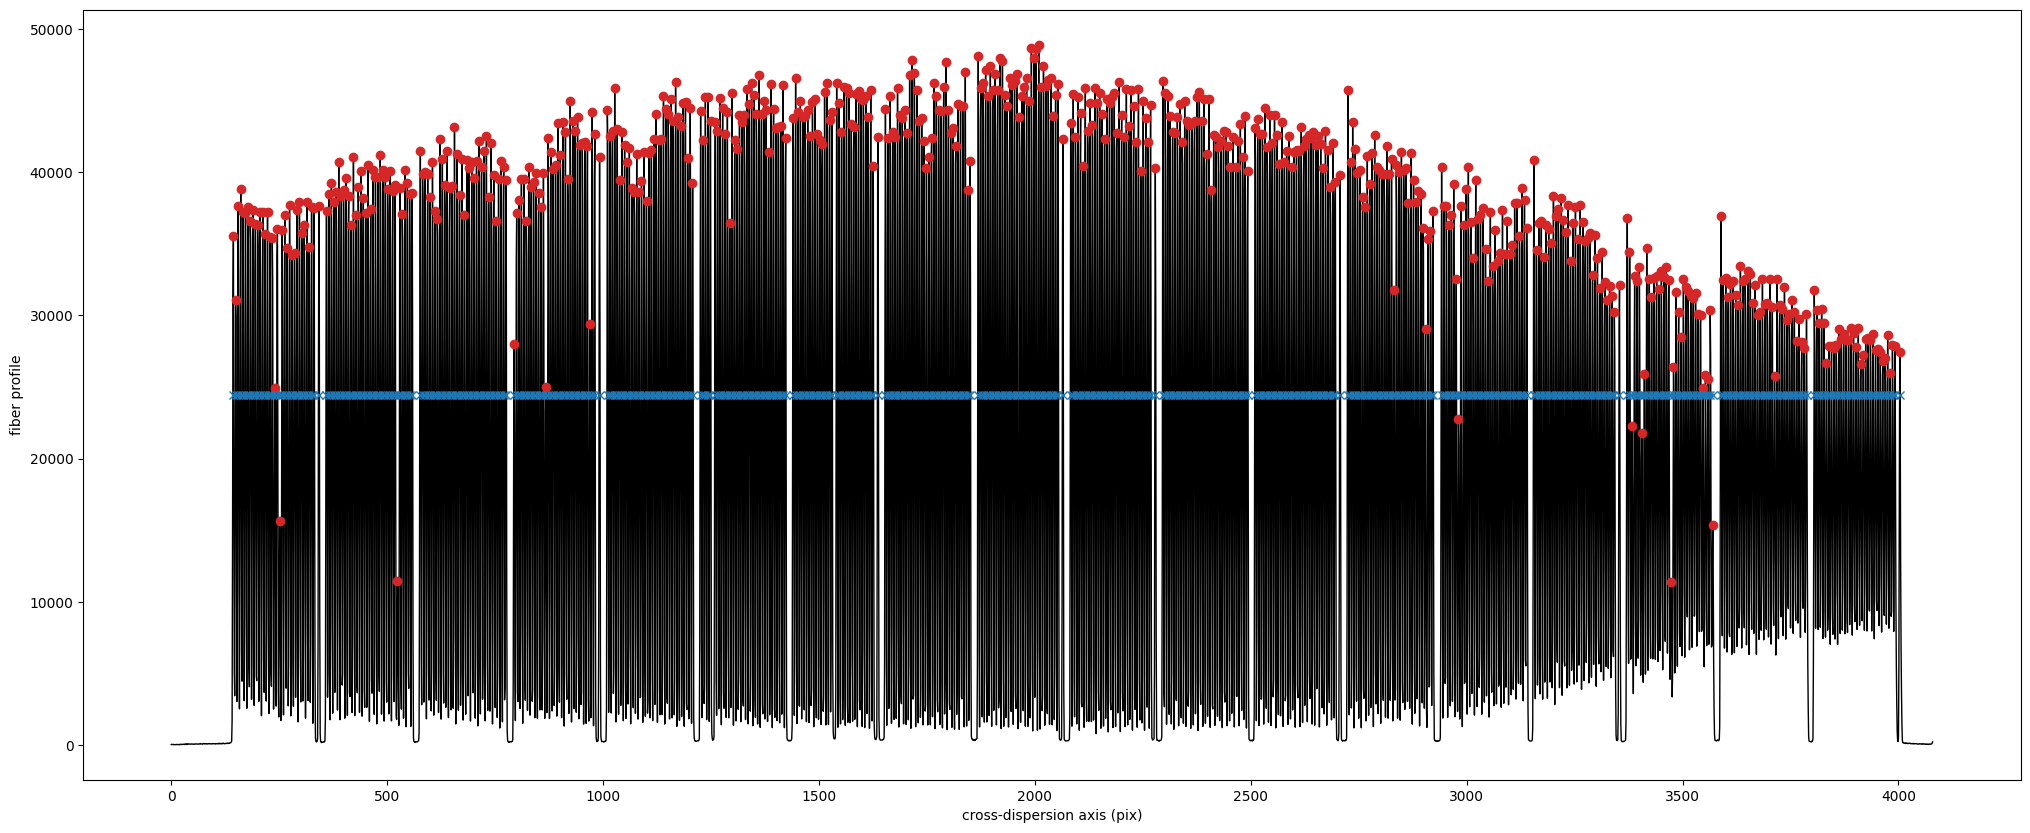

[WARNING]: divide by zero encountered in divide (RuntimeWarning)
[WARNING]: invalid value encountered in divide (RuntimeWarning)


In [7]:
fiberflat_camera = "r1"

imageMethod.findPeaksAuto_drp(
            in_image=os.path.join(output_path, f"lvm-cfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
            out_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-{fiberflat_expnum}.txt"),
            nfibers=0, slice=1870, threshold=10000, method="hyperbolic", median_box=0, median_cross=0, verbose=True
        )
imageMethod.tracePeaks_drp(
        in_image=os.path.join(output_path, f"lvm-cfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
        out_trace=os.path.join(output_path, f"lvm-trace-{fiberflat_camera}-{fiberflat_expnum}.fits"),
        in_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-{fiberflat_expnum}.txt"),
        steps=10, coadd=10, threshold_peak=10000, max_diff=2, method="hyperbolic", median_box=0, median_cross=0, verbose=True
    )

637 Fibers found


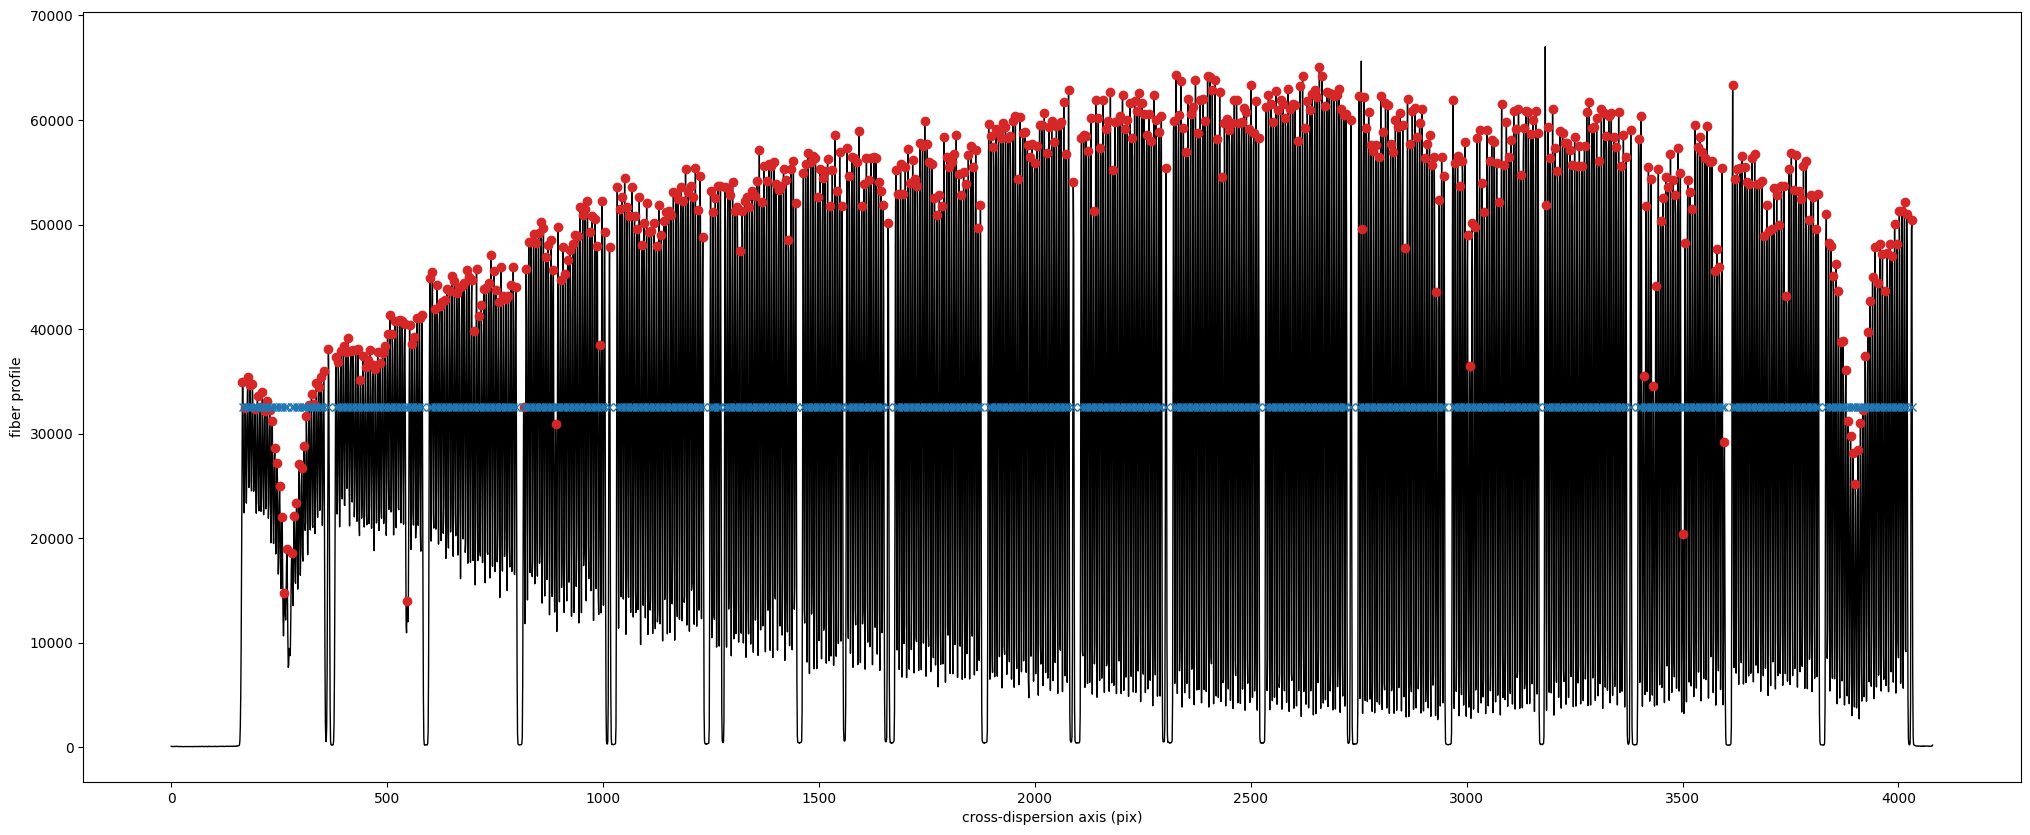

In [8]:
fiberflat_camera = "z1"

imageMethod.findPeaksAuto_drp(
            in_image=os.path.join(output_path, f"lvm-cfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
            out_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-{fiberflat_expnum}.txt"),
            nfibers=0, slice=1870, threshold=10000, method="hyperbolic", median_box=0, median_cross=0, verbose=True
        )
imageMethod.tracePeaks_drp(
        in_image=os.path.join(output_path, f"lvm-cfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
        out_trace=os.path.join(output_path, f"lvm-trace-{fiberflat_camera}-{fiberflat_expnum}.fits"),
        in_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-{fiberflat_expnum}.txt"),
        steps=10, coadd=10, threshold_peak=10000, max_diff=2, method="hyperbolic", median_box=0, median_cross=0, verbose=True
    )

In [9]:
CHANNEL_WL = {"b1": (3600, 5930), "r1": (5660, 7720), "z1": (7470, 9800)}

ised = 319
coad = 5

for fiberflat_frame, arc_frame in zip(fiberflats, arcs):
    fiberflat_path = fiberflat_frame["path"]
    fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]
    arc_path = arc_frame["path"]
    arc_camera, arc_expnum = arc_frame["camera"], arc_frame["expnum"]
    
    if arc_camera == "b1": continue
    
    wave_range = CHANNEL_WL[arc_camera]

    imageMethod.extractSpec_drp(
        in_image=out_path.format(kind="carc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        in_trace=out_path.format(kind="trace", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        method="aperture", aperture=4, plot=1, parallel="auto"
    )

    rssMethod.detWaveSolution_drp(
        in_arc=out_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_wave=out_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_lsf=out_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        in_ref_lines=f"../../python/lvmdrp/etc/lvm-neon_nist_{arc_camera}.txt",
        ref_fiber=ised, poly_dispersion=-3, poly_fwhm='-3,-1', aperture=13, verbose=1
    )

    rssMethod.createPixTable_drp(
        in_rss=out_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_path.format(kind="warc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_wave=out_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_fwhm=out_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits")
    )
    
    rssMethod.resampleWave_drp(
        in_rss=out_path.format(kind="warc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_path.format(kind="harc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        start_wave=wave_range[0], end_wave=wave_range[1], disp_pix=1.0, method="linear",
        err_sim=10, parallel="auto", extrapolate=True
    )

measuring arc lines upwards from 319:  94%|######################################################5   | 300/319 [00:13<00:00, 23.62fiber/s]

[WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)


measuring arc lines downwards from 319: 100%|########################################################| 317/317 [00:08<00:00, 36.11fiber/s]


Text(0.5, 1.0, "camera = 'z1'")

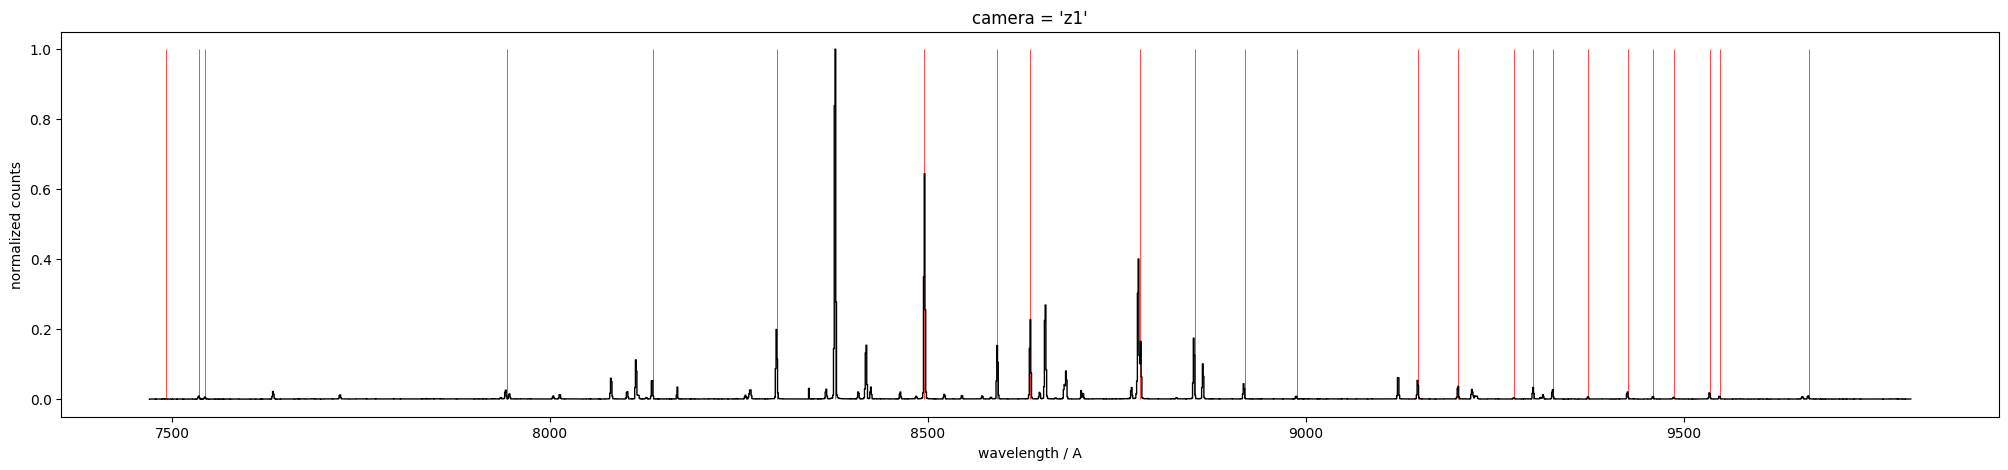

In [10]:
camera = "z1"

harc = rss.RSS()
harc.loadFitsData(out_path.format(kind="harc", camera=camera, expnum=arc_expnum, ext="fits"))

# with open(out_path.format(kind="pixwave", camera=camera, expnum=arc_expnum, ext="txt")) as f:
with open(f"../../python/lvmdrp/etc/lvm-neon_nist_{camera}.txt") as f:
    f.readline()
    lines_wav = []
    for line in f.readlines():
        _, line_wav, _ = line[:-1].split()
        lines_wav.append(float(line_wav))
    lines_wav = np.asarray(lines_wav)
    lines_int = np.ones_like(lines_wav)
    lines_min = np.zeros_like(lines_wav)

plt.figure(figsize=(25,5))
plt.vlines(lines_wav, lines_min, lines_int / lines_int, lw=0.5, ls="-", color="r")
plt.step(harc._wave, harc._data[ised]/np.nanmax(harc._data[ised]), color="k", lw=1)
plt.xlabel("wavelength / A")
plt.ylabel("normalized counts")
plt.title(f"{camera = }")
# plt.gca().set_yscale("log")

In [11]:
for fiberflat_frame, arc_frame in zip(fiberflats, arcs):
    fiberflat_path = fiberflat_frame["path"]
    fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]
    arc_path = arc_frame["path"]
    arc_camera, arc_expnum = arc_frame["camera"], arc_frame["expnum"]
    
    if arc_camera == "b1": continue
    
    wave_range = CHANNEL_WL[arc_camera]

    imageMethod.extractSpec_drp(
        in_image=out_path.format(kind="cfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        out_rss=out_path.format(kind="xfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        in_trace=out_path.format(kind="trace", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        method="aperture", aperture=4, plot=1, parallel="auto"
    )
    
    rssMethod.createPixTable_drp(
        in_rss=out_path.format(kind="xfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        out_rss=out_path.format(kind="wfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        arc_wave=out_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_fwhm=out_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits")
    )
    
    rssMethod.resampleWave_drp(
        in_rss=out_path.format(kind="wfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        out_rss=out_path.format(kind="hfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        start_wave=wave_range[0], end_wave=wave_range[1], disp_pix=1.0, method="linear",
        err_sim=10, parallel="auto", extrapolate=True
    )

Text(0, 0.5, 'counts (e-/pix)')

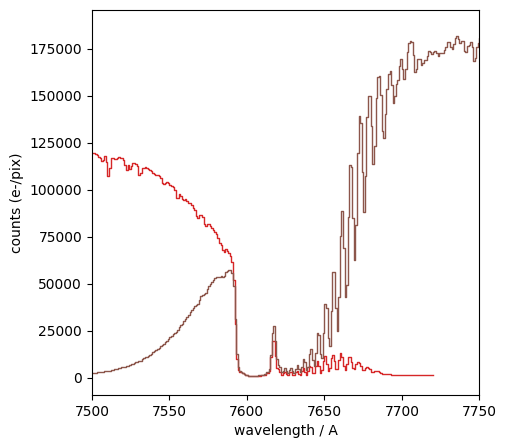

In [12]:
twilight_r = rss.RSS()
twilight_r.loadFitsData(out_path.format(kind="hfiberflat", camera="r1", expnum=fiberflat_expnum, ext="fits"))
superflat_r = twilight_r.create1DSpec()

twilight_z = rss.RSS()
twilight_z.loadFitsData(out_path.format(kind="hfiberflat", camera="z1", expnum=fiberflat_expnum, ext="fits"))
superflat_z = twilight_z.create1DSpec()

plt.figure(figsize=(5,5))
plt.step(superflat_r._wave, superflat_r._data, color="tab:red", lw=1)
plt.step(superflat_z._wave, superflat_z._data, color="tab:brown", lw=1)
plt.xlim(7500,7750)
plt.xlabel("wavelength / A")
plt.ylabel("counts (e-/pix)")

In [13]:
objects = frames_groups[(unique_groups["imagetyp"]=="object")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00000209")]
objects.pprint(max_width=200)

for object_frame, fiberflat_frame, arc_frame in zip(objects, fiberflats, arcs):
    fiberflat_path = fiberflat_frame["path"]
    fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]
    arc_path = arc_frame["path"]
    arc_camera, arc_expnum = arc_frame["camera"], arc_frame["expnum"]
    object_path = object_frame["path"]
    object_camera, object_expnum = object_frame["camera"], object_frame["expnum"]
    
    if arc_camera == "b1": continue
    
    wave_range = CHANNEL_WL[arc_camera]
    
    imageMethod.preprocRawFrame_drp(
        in_image=object_path,
        out_image=out_path.format(kind="pobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        subtract_overscan=True, unit="e-", compute_error=True,
        assume_imagetyp="object"
    )
    # imageMethod.LACosmic_drp(
    #     in_image=out_path.format(kind="pobject", camera=object_camera, expnum=object_expnum, ext="fits"),
    #     out_image=out_path.format(kind="robject", camera=object_camera, expnum=object_expnum, ext="fits"),
    #     iter=3, increase_radius=1, flim=1.3, parallel="auto"
    # )
    imageMethod.basicCalibration_drp(
        in_image=out_path.format(kind="pobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        out_image=out_path.format(kind="cobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        # in_bias=out_path.format(kind="pbias", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        # in_pixelflat=mpixelflat_path.format(camera=arc_camera, ext="fits")
    )
    
    imageMethod.extractSpec_drp(
        in_image=out_path.format(kind="cobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        out_rss=out_path.format(kind="xobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        in_trace=out_path.format(kind="trace", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        method="aperture", aperture=4, plot=1, parallel="auto"
    )
    
    rssMethod.createPixTable_drp(
        in_rss=out_path.format(kind="xobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        out_rss=out_path.format(kind="wobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        arc_wave=out_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_fwhm=out_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits")
    )
    
    rssMethod.resampleWave_drp(
        in_rss=out_path.format(kind="wobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        out_rss=out_path.format(kind="hobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        start_wave=wave_range[0], end_wave=wave_range[1], disp_pix=1.0, method="linear",
        err_sim=10, parallel="auto", extrapolate=True
    )

imagetyp spec camera  expnum  exptime                                                                   path                                                                 
-------- ---- ------ -------- ------- ---------------------------------------------------------------------------------------------------------------------------------------
  object  sp1     b1 00000209   900.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60011/sdR-s-b1-00000209.fits.gz
  object  sp1     r1 00000209   900.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60011/sdR-s-r1-00000209.fits.gz
  object  sp1     z1 00000209   900.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60011/sdR-s-z1-00000209.fits.gz


Text(0.5, 1.0, "object_expnum = '00000209'")

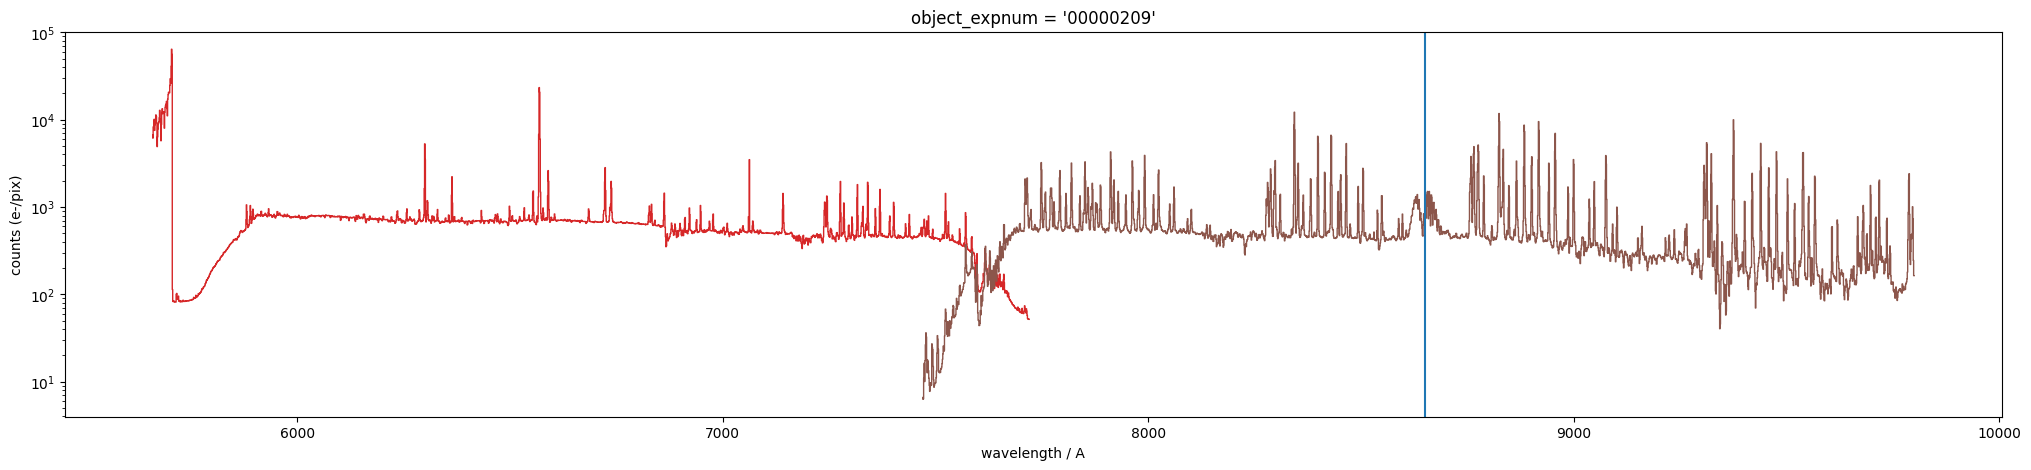

In [14]:
object_r = rss.RSS()
object_r.loadFitsData(out_path.format(kind="hobject", camera="r1", expnum=object_expnum, ext="fits"))
superobject_r = object_r.create1DSpec()
superobject_r._inst_fwhm = superobject_r._inst_fwhm.mean(axis=0)

object_z = rss.RSS()
object_z.loadFitsData(out_path.format(kind="hobject", camera="z1", expnum=object_expnum, ext="fits"))
superobject_z = object_z.create1DSpec()
superobject_z._inst_fwhm = superobject_z._inst_fwhm.mean(axis=0)

superobject = superobject_r.coaddSpec(superobject_z)

plt.figure(figsize=(25,5))
plt.step(superobject_r._wave, superobject_r._data, color="tab:red", lw=1)
plt.step(superobject_z._wave, superobject_z._data, color="tab:brown", lw=1)
# plt.step(superobject._wave, superobject._data, color="0.2", lw=1)
plt.gca().set_yscale("log")
plt.axvline(8650)
# plt.ylim(-500, 3000)
# plt.xlim(7500, 8000)
plt.xlabel("wavelength / A")
plt.ylabel("counts (e-/pix)")
plt.title(f"{object_expnum = }")